# Kaggle & Colab Imports

In [ ]:
%%capture
# KAGGLE IMPORTS
# Clone repo
!git clone https://github.com/francinze/Ch_An2DL.git /kaggle/working/ch2

# Install kaggle API
!pip install -q kaggle

# Configure kaggle.json
!mkdir -p /root/.config/kaggle

# Copy your kaggle.json there
!cp /kaggle/working/ch2/kaggle.json /root/.config/kaggle/

# Set correct permissions
!chmod 600 /root/.config/kaggle/kaggle.json

# Move into the working directory
%cd /kaggle/working/ch2/

!mkdir -p data
!mkdir -p models

# Download competition files WITH CORRECT PATH
!kaggle competitions download -c an2dl2526c2v2 -p ./data/

# Unzip dataset WITH CORRECT PATH
!unzip -o ./data/an2dl2526c2v2.zip -d ./data/

# Verify download
!ls -la ./data/
!echo "Download complete!"

!rm -rf ./data/an2dl2526c2v2.zip

In [ ]:
'''
%%capture
# COLAB IMPORTS
!git clone https://github.com/francinze/Ch_An2DL.git
! pip install -q kaggle
! mkdir ~/.kaggle
! cp Ch_An2DL/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
%cd /content/Ch_An2DL/
!mkdir data
!mkdir models
!kaggle competitions download -c an2dl2526c2v2 -p /data
!unzip -o /data/an2dl2526c2v2.zip -d /data/
'''

#  Import data

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

## Organize Data by Type

In [2]:
import os
import shutil

# Detect environment and set appropriate path prefix
if os.path.exists('./data/train_data'):
    PATH_PREFIX = './'
    print("✓ Found ./data/train_data (Local or Colab)")
elif os.path.exists('/data/train_data'):
    PATH_PREFIX = '/'
    print("✓ Found /data/train_data (Kaggle)")
elif os.path.exists('data/train_data'):
    PATH_PREFIX = ''
    print("✓ Found data/train_data (Current directory)")
else:
    print("✗ Data not found in expected locations!")
    PATH_PREFIX = '/'

print(f"Using PATH_PREFIX: {PATH_PREFIX}")

print("="*80)
print("ORGANIZING DATA INTO SEPARATE DIRECTORIES BY TYPE")
print("="*80)

# Define source directories
train_data_dir = PATH_PREFIX + 'data/train_data/'
test_data_dir = PATH_PREFIX + 'data/test_data/'

# Define target directories for organized data
train_img_dir = PATH_PREFIX + 'data/train_img/'
train_mask_dir = PATH_PREFIX + 'data/train_mask/'
test_img_dir = PATH_PREFIX + 'data/test_img/'
test_mask_dir = PATH_PREFIX + 'data/test_mask/'

train_labels = pd.read_csv(PATH_PREFIX + 'data/train_labels.csv')

# Create target directories if they don't exist
for directory in [train_img_dir, train_mask_dir, test_img_dir, test_mask_dir]:
    os.makedirs(directory, exist_ok=True)

# Function to organize files by type
def organize_data_by_type(source_dir, img_dir, mask_dir):
    """
    Move image and mask files from source directory to separate directories.
    Only moves files if they don't already exist in the target directory.
    """
    if not os.path.exists(source_dir):
        print(f"⚠ Warning: Source directory not found: {source_dir}")
        return 0, 0
    
    files = os.listdir(source_dir)
    img_count = 0
    mask_count = 0
    
    for filename in files:
        source_path = os.path.join(source_dir, filename)
        
        # Skip if not a file
        if not os.path.isfile(source_path):
            continue
        
        # Determine target directory based on filename prefix
        if filename.startswith('img_'):
            target_path = os.path.join(img_dir, filename)
            if not os.path.exists(target_path):
                shutil.copy2(source_path, target_path)
                img_count += 1
        elif filename.startswith('mask_'):
            target_path = os.path.join(mask_dir, filename)
            if not os.path.exists(target_path):
                shutil.copy2(source_path, target_path)
                mask_count += 1
    
    return img_count, mask_count

# Organize training data
print("\nOrganizing training data...")
train_img_moved, train_mask_moved = organize_data_by_type(
    train_data_dir, train_img_dir, train_mask_dir
)
print(f"  Images: {train_img_moved} files copied to {train_img_dir}")
print(f"  Masks: {train_mask_moved} files copied to {train_mask_dir}")

# Organize test data
print("\nOrganizing test data...")
test_img_moved, test_mask_moved = organize_data_by_type(
    test_data_dir, test_img_dir, test_mask_dir
)
print(f"  Images: {test_img_moved} files copied to {test_img_dir}")
print(f"  Masks: {test_mask_moved} files copied to {test_mask_dir}")

# Verify organization
print("\n" + "="*80)
print("DATA ORGANIZATION SUMMARY")
print("="*80)
print(f"Train images: {len(os.listdir(train_img_dir)) if os.path.exists(train_img_dir) else 0} files in {train_img_dir}")
print(f"Train masks: {len(os.listdir(train_mask_dir)) if os.path.exists(train_mask_dir) else 0} files in {train_mask_dir}")
print(f"Test images: {len(os.listdir(test_img_dir)) if os.path.exists(test_img_dir) else 0} files in {test_img_dir}")
print(f"Test masks: {len(os.listdir(test_mask_dir)) if os.path.exists(test_mask_dir) else 0} files in {test_mask_dir}")
print("="*80)
print("Data organization complete!")
print("  - Organized copies are in train_img/, train_mask/, test_img/, test_mask/")

✓ Found ./data/train_data (Local or Colab)
Using PATH_PREFIX: ./
ORGANIZING DATA INTO SEPARATE DIRECTORIES BY TYPE

Organizing training data...
  Images: 581 files copied to ./data/train_img/
  Masks: 0 files copied to ./data/train_mask/

Organizing test data...
  Images: 477 files copied to ./data/test_img/
  Masks: 0 files copied to ./data/test_mask/

DATA ORGANIZATION SUMMARY
Train images: 4581 files in ./data/train_img/
Train masks: 4000 files in ./data/train_mask/
Test images: 954 files in ./data/test_img/
Test masks: 477 files in ./data/test_mask/
Data organization complete!
  - Organized copies are in train_img/, train_mask/, test_img/, test_mask/


# Preprocessing

## Remove Shrek & Slimes

In [3]:
# Parse the contaminated indices from the text file
contaminated_indices = []
with open('shrek_and_slimes.txt', 'r') as f:
    for line in f:
        line = line.strip()
        if line and line.isdigit():
            contaminated_indices.append(int(line))

print(f"Found {len(contaminated_indices)} contaminated samples to remove")

# Define directories to clean (both img and mask directories)
train_img_dir_clean = PATH_PREFIX + 'data/train_img/'
train_mask_dir_clean = PATH_PREFIX + 'data/train_mask/'

# Remove corresponding image and mask files from both directories
removed_count = 0
for idx in contaminated_indices:
    img_name = f'img_{idx:04d}.png'
    mask_name = f'mask_{idx:04d}.png'
    
    # Remove from train_img directory
    img_path = os.path.join(train_img_dir_clean, img_name)
    if os.path.exists(img_path):
        os.remove(img_path)
        removed_count += 1
    
    # Remove from train_mask directory
    mask_path = os.path.join(train_mask_dir_clean, mask_name)
    if os.path.exists(mask_path):
        os.remove(mask_path)
        removed_count += 1

print(f"Removed {removed_count} files from organized directories")

# Update train_labels by removing contaminated indices
train_labels = train_labels[~train_labels['sample_index'].str.extract(r'(\d+)')[0].astype(int).isin(contaminated_indices)]
print(f"Training labels updated: {len(train_labels)} samples remaining")

Found 110 contaminated samples to remove
Removed 0 files from organized directories
Training labels updated: 581 samples remaining


## Masks as Focus Filters

## Generative Mask Conditioning

**Philosophy**: *"Few images you have? But the shapes (masks) you possess. Use a generative model, conditioned on these masks, to dream new textures into old forms."*

**Pipeline**:
```
Original Images + Masks
    ↓
[GENERATIVE] Generate synthetic images from masks
    ↓
Real + Synthetic Images (with masks)
    ↓
[AUGMENTATION] Geometric transforms on all
    ↓
Maximum Diversity Dataset
```

Found 1 GPU(s) available:
 GPU 0: NVIDIA GeForce GTX 1650 with Max-Q Design
Single GPU training
GENERATIVE MASK CONDITIONING SETUP (Pix2Pix GAN)
Adding synthetic images to: ./data/train_img/
Adding synthetic masks to: ./data/train_mask/
Synthetic multiplier: 3x per image
Using GPU: True
Method: Lightweight Pix2Pix GAN (~50MB)
✓ Pix2Pix Generator initialized
  Parameters: 6,171,651
  Size: ~23.5 MB
  Device: GPU

✓ Class-specific color profiles defined
  Classes: ['Triple negative', 'Luminal A', 'Luminal B', 'HER2(+)']
✓ Helper functions defined
  - prepare_mask_for_gan(): Convert masks to GAN tensor format
  - apply_color_jitter(): Class-specific color augmentation
  - generate_synthetic_image_gan(): GAN-based generation with blending

GENERATING SYNTHETIC IMAGES FROM MASKS
Generating 3 synthetic images per real image
Total real images: 581
Expected synthetic images: 1743

  Progress: 10/581 images processed (30 synthetic images generated)
  Progress: 20/581 images processed (60 synthe

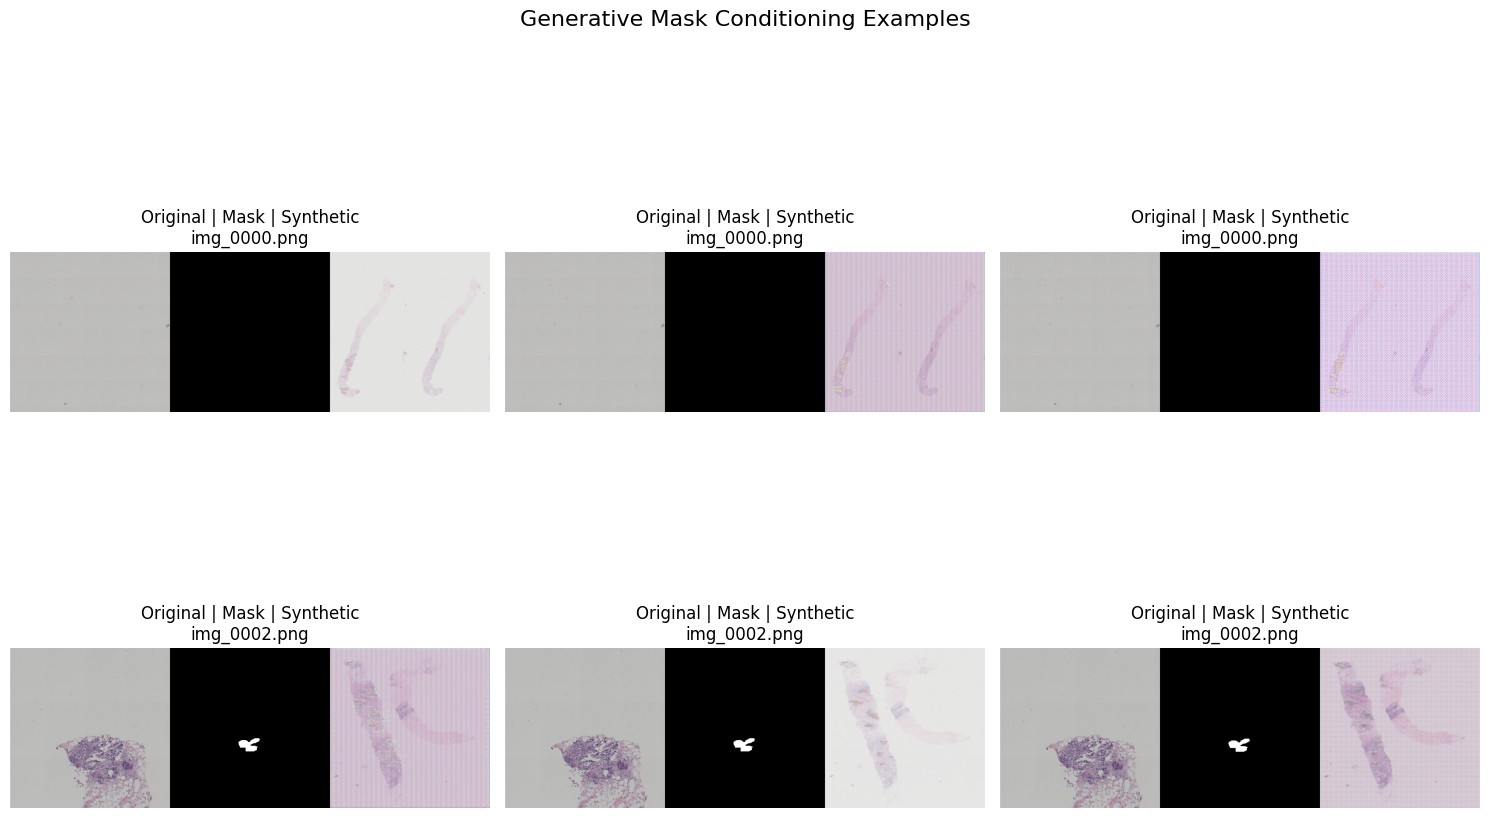


✓ Showing 6 synthetic examples
  Left: Original image | Center: Mask (guide) | Right: Synthetic image
Found 1743 synthetic images in existing directory

Dataset expansion complete:
  Real images: 581
  Synthetic images: 1743
  Total: 2324
  Expansion ratio: 4.00x

Class distribution (Real + Synthetic):
label
HER2(+)            600
Luminal A          632
Luminal B          816
Triple negative    276
Name: count, dtype: int64


In [4]:
from prep_gen_mask import generate_synthetic_images

train_labels = generate_synthetic_images(train_img_dir, train_mask_dir, train_labels, synthetic_multiplier=3)

## Augmentation


Class Distribution After Removal of Contaminated Images
label
HER2(+)            600
Luminal A          632
Luminal B          816
Triple negative    276
Name: count, dtype: int64

Total samples: 2324

STATISTICS FOR AUGMENTATION

Class with the most samples (Majority): Luminal B (816 samples)
Class with the fewest samples (Minority): Triple negative (276 samples)

Imbalance ratio (Max/Min): 2.96x

RECOMMENDED AUGMENTATION STRATEGY

Augmentations to apply (as suggested by the professor):
  1. Horizontal Flip (p=0.5)
  2. Vertical Flip (p=0.5)
  3. Random Translation (0.2, 0.2)
  4. Random Zoom/Scale (0.8, 1.2)
  [EXCLUDE: Random Rotation - would change dimensions]


BALANCED STRATEGY: ALL CLASSES GROW TO A FIXED AND EQUAL NUMBER

Target: 1000 samples for EACH class

DATASET AFTER BALANCED AUGMENTATION
Class                Original        New Augment     Augmentations per image   Total          
--------------------------------------------------------------------------------
HER2(+)   

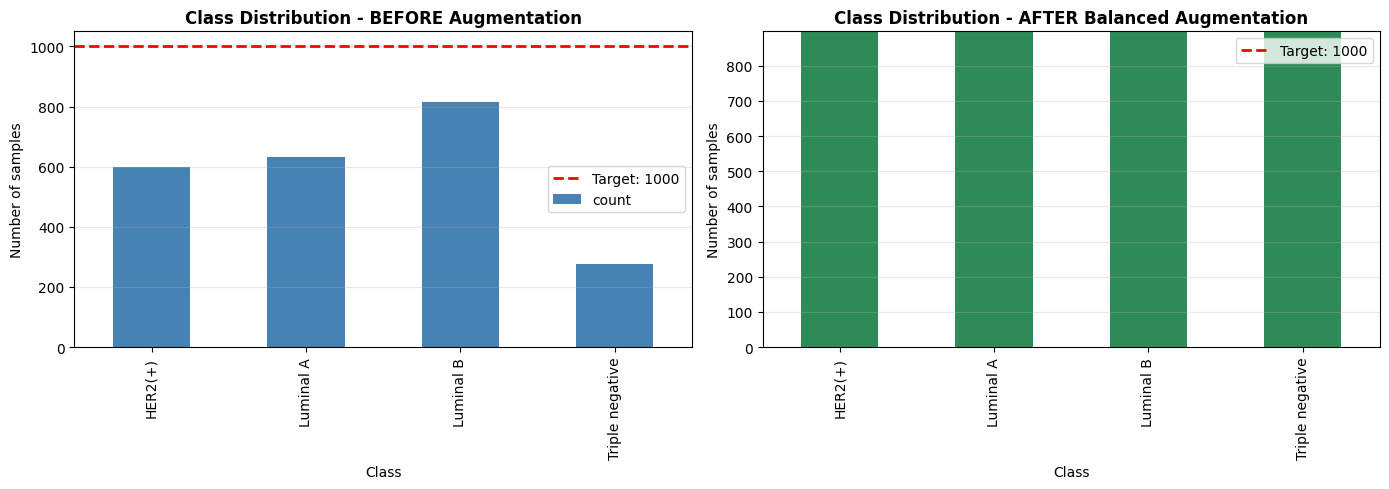


AUTOMATIC AUGMENTATION CONFIGURATION
Using AutoAugment with policy: AutoAugmentPolicy.IMAGENET
  - Automatically applies learned augmentation combinations
  - Optimized for ImageNet-like datasets

Mask augmentation:
  - Synchronized geometric transforms only (flip operations)
  - No color/brightness changes (masks are binary/grayscale)

Augmentation pipeline ready!

STARTING DUAL-PATH AUTOMATIC AUGMENTATION PROCESS
Augmentation Policy: autoaugment
Augmenting both IMAGES and MASKS
  - Images: Automatic augmentation (color, geometric, etc.)
  - Masks: Synchronized geometric transforms only
Saving augmented files to same directories as originals

--------------------------------------------------------------------------------
Class: HER2(+)
Augmentations to generate: 400
--------------------------------------------------------------------------------


  HER2(+): 100%|██████████| 600/600 [00:36<00:00, 16.62it/s]


  HER2(+): Completed! 400 image-mask pairs generated

--------------------------------------------------------------------------------
Class: Luminal A
Augmentations to generate: 368
--------------------------------------------------------------------------------


  Luminal A: 100%|██████████| 632/632 [00:34<00:00, 18.28it/s]


  Luminal A: Completed! 368 image-mask pairs generated

--------------------------------------------------------------------------------
Class: Luminal B
Augmentations to generate: 184
--------------------------------------------------------------------------------


  Luminal B: 100%|██████████| 816/816 [00:34<00:00, 23.36it/s]


  Luminal B: Completed! 184 image-mask pairs generated

--------------------------------------------------------------------------------
Class: Triple negative
Augmentations to generate: 724
--------------------------------------------------------------------------------


  Triple negative: 100%|██████████| 276/276 [00:39<00:00,  7.05it/s]


  Triple negative: Completed! 724 image-mask pairs generated

AUTOMATIC AUGMENTATION COMPLETED!
Total augmented image-mask pairs generated: 1676
Augmented images added to: ./data/train_img/
Augmented masks added to: ./data/train_mask/

Total images in directory: 4581
Total masks in directory: 4000


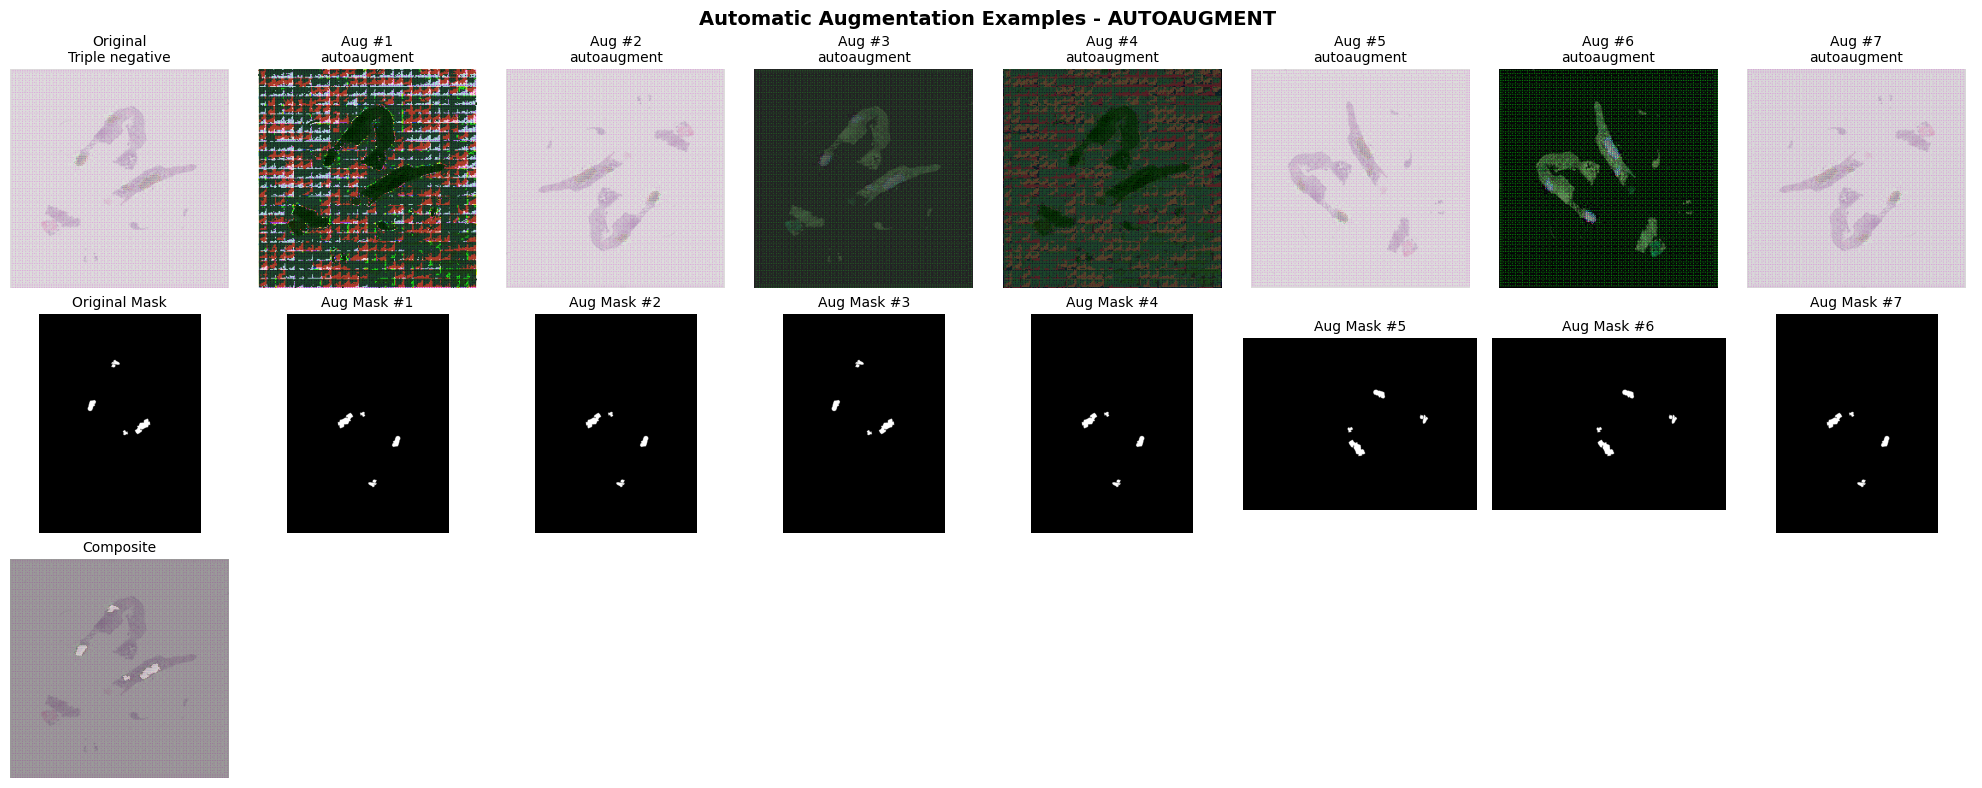


✓ Showing 8 augmentation variations
  Policy: autoaugment
  Notice the variety in color, brightness, contrast, and geometric transforms


In [5]:
from prep_aug import augment_images

train_labels = augment_images(train_img_dir, train_mask_dir, train_labels, augmentation_policy='autoaugment', target_samples=1000)

## Crop Masked Images

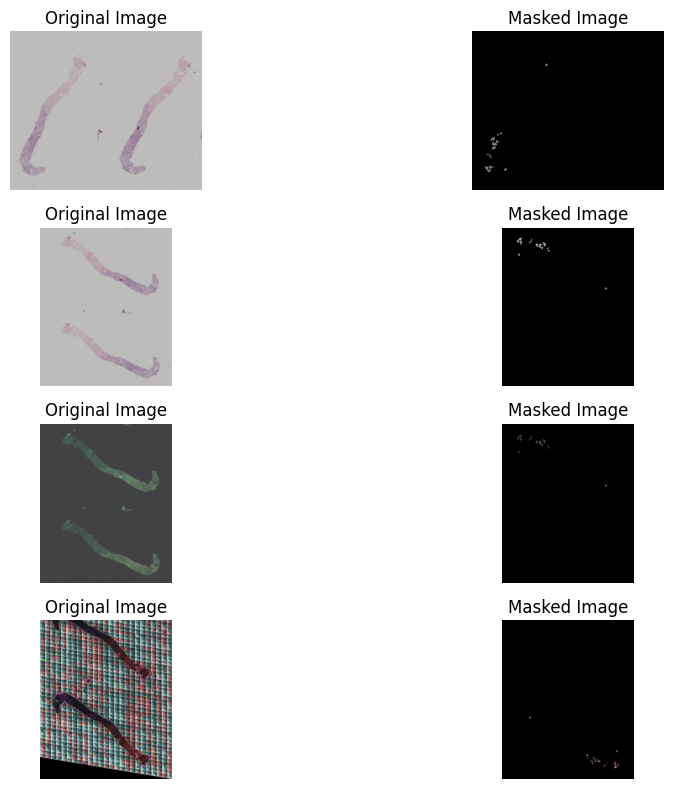

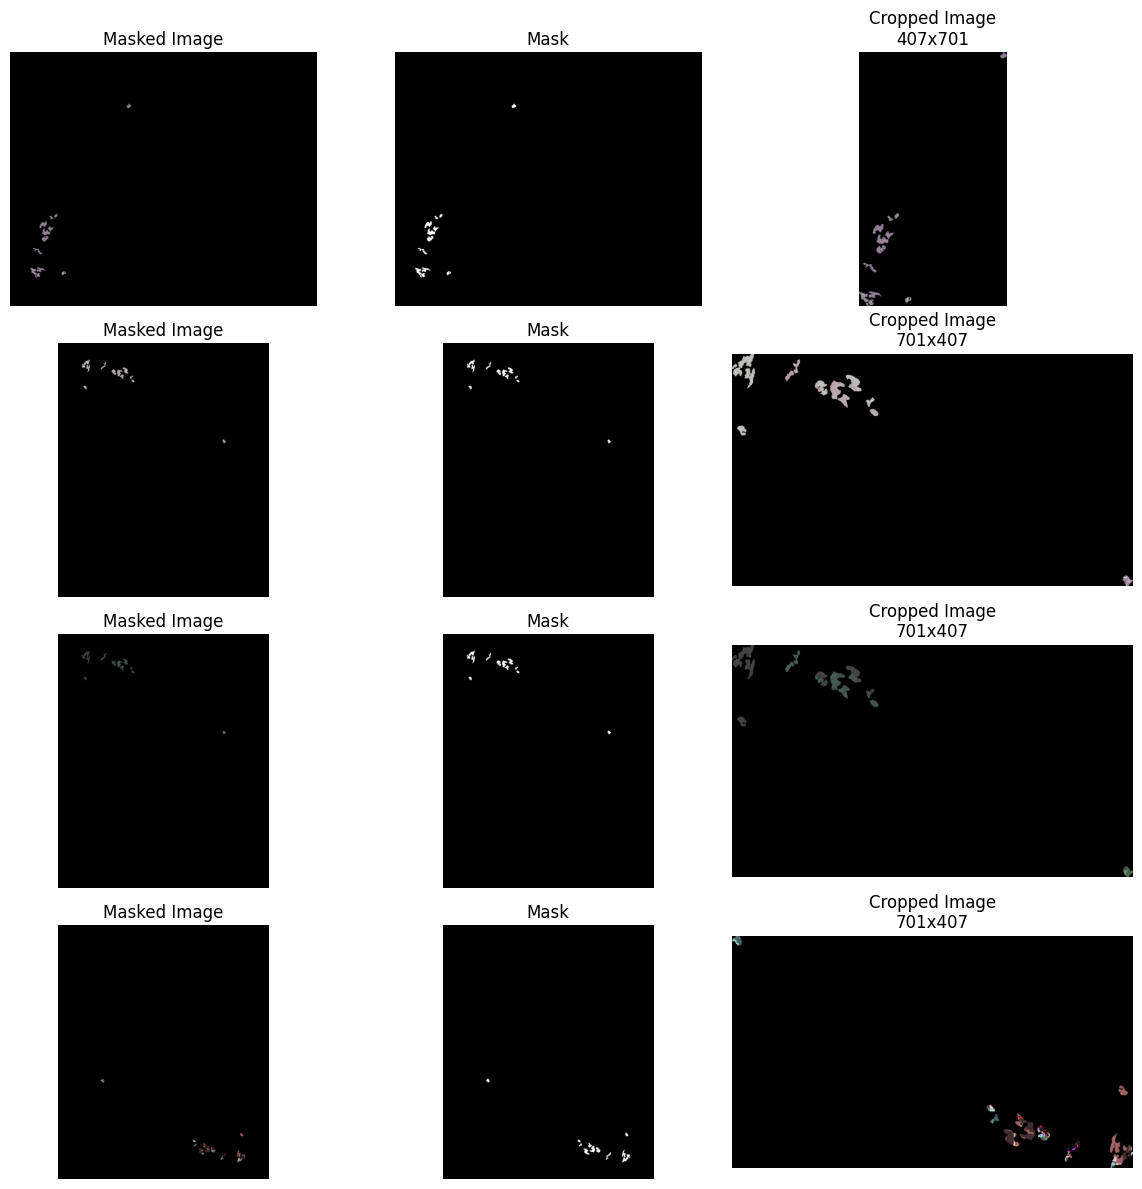

Processing training images: 100%|██████████| 4000/4000 [04:52<00:00, 13.68it/s]



Masked and cropped training images saved.


Processing test images: 100%|██████████| 477/477 [01:48<00:00,  4.40it/s]



Masked and cropped test images saved.


In [6]:
import importlib
import prep_focusfilter
importlib.reload(prep_focusfilter)
from prep_focusfilter import focus_filter

train_labels = focus_filter(train_img_dir, train_mask_dir, test_img_dir, test_mask_dir, train_labels=train_labels, min_size=(256, 256))

# Dataloaders

In [21]:
import importlib
import load_patches
importlib.reload(load_patches)
from load_patches import load_patches
from load_images import load_images

# ===== PATCH-BASED PROCESSING SETTINGS =====
# Instead of resizing images to 224x224 (which loses detail),
# we extract patches at full resolution and process them separately
PATCH_SIZE = 256  # Size of each patch (256x256)
PATCH_STRIDE = 64
# ==========================================

# For backward compatibility when not using patches
IMG_SIZE = (224, 224) if not PATCH_SIZE and not PATCH_STRIDE else (PATCH_SIZE, PATCH_SIZE)

# Create DataLoaders
# Larger batch size for multi-GPU: DataParallel splits batch across GPUs
# With 2 GPUs: effective batch per GPU = BATCH_SIZE / 2
BATCH_SIZE = 128  # 64 per GPU with DataParallel

## MUTUALLY EXCLUSIVE: Choose either patch-based or full-image loading
# 1) Patch-based loading
train_loader, val_loader, test_loader, input_shape, num_classes = load_patches(
    train_img_dir,
    test_img_dir,
    train_labels,
    path_prefix=PATH_PREFIX,
    patch_size=PATCH_SIZE,
    patch_stride=PATCH_STRIDE,
    batch_size=BATCH_SIZE,
    images_per_batch=16
)

# # 2) Full-image loading
# train_loader, val_loader, test_loader, input_shape, num_classes = load_images(
#     train_img_dir,
#     test_img_dir,
#     train_labels,
#     img_size=IMG_SIZE,
#     batch_size=BATCH_SIZE
# )

GPU detected: 1 GPU(s) - using 2 workers

LOADING IMAGES

Distribution in dataset:
label
HER2(+)            1000
Luminal A          1000
Luminal B          1000
Triple negative    1000
Name: count, dtype: int64

PATCH PRE-EXTRACTION (Multi-File Strategy)
✓ Found pre-extracted patches!
  Loading metadata from: ./data\patches_cache\metadata_ps256_stride64.json
✓ Found 250 batch files with 24668 total patches

Creating multi-file dataset...
Total patches: 24668
Loading batch metadata from 250 files...


c:\Users\frain\Documents\GitHub\Ch_An2DL\load_patches.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  print("LOADING IMAGES")


Dataset ready with 24668 patches (all batches cached in RAM)

CREATING TRAIN/VAL SPLIT
Loading all labels for stratified split...


c:\Users\frain\Documents\GitHub\Ch_An2DL\load_patches.py:343: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  print(f"Total test patches: {self.total_patches}")


Train patches: 19734
Val patches: 4934

Optimization: 2 workers, pin_memory=True, persistent_workers=True

Created DataLoaders:
Train batches: 155
Val batches: 39
Using PATCH-BASED processing for test data
Computing patch counts for 477 test images...
  Processed 100/477 images...
  Processed 200/477 images...
  Processed 300/477 images...
  Processed 400/477 images...
Total test patches: 15412
Test patches: 15412
Test image files: 477

DataLoader created:
Test batches: 121
Optimization: 2 workers, pin_memory=True


In [22]:
import torch
# ===== MULTI-GPU SETUP =====
# Check for multiple GPUs and set up DataParallel
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    device = torch.device('cuda:0')
    print(f"Found {num_gpus} GPU(s) available:")
    for i in range(num_gpus):
        print(f" GPU {i}: {torch.cuda.get_device_name(i)}")
    if num_gpus > 1:
        print(f"Multi-GPU training enabled: Will use {num_gpus} GPUs with DataParallel")
    else:
        print(f"Single GPU training")
else:
    device = torch.device('cpu')
    num_gpus = 0
    print("No GPU available, using CPU")
# ===========================

Found 1 GPU(s) available:
 GPU 0: NVIDIA GeForce GTX 1650 with Max-Q Design
Single GPU training


# Parameters

In [23]:
import torch.nn as nn

# Number of training epochs
LEARNING_RATE = 1e-3
EPOCHS = 300
PATIENCE = 50

# Regularisation
DROPOUT_RATE = 0.5       # Dropout probability
L1_LAMBDA = 0.001           # L1 penalty
L2_LAMBDA = 0.01         # L2 penalty

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Print the defined parameters
print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rate:", LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("L1 Penalty:", L1_LAMBDA)
print("L2 Penalty:", L2_LAMBDA)

Epochs: 300
Batch Size: 128
Learning Rate: 0.001
Dropout Rate: 0.5
L1 Penalty: 0.001
L2 Penalty: 0.01


# Model Builder

In [36]:
import torchvision.models as models
from torchvision.models import ResNet18_Weights, ResNet50_Weights, EfficientNet_B0_Weights, EfficientNet_B3_Weights, VGG16_Weights

# ===== UNCOMMENT THE MODEL YOU WANT TO USE =====

# ResNet-18 (Smaller, faster)
model_pretrained = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
MODEL_NAME = "resnet18"

# ResNet-50 (Deeper, more powerful)
# model_pretrained = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
# MODEL_NAME = "resnet50"

# EfficientNet-B0 (Efficient, good balance)
# model_pretrained = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
# MODEL_NAME = "efficientnet_b0"

# EfficientNet-B3 (More powerful EfficientNet)
# model_pretrained = models.efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
# MODEL_NAME = "efficientnet_b3"

# VGG-16 (Classic architecture)
# model_pretrained = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
# MODEL_NAME = "vgg16"

# ===============================================

print(f"Loaded pretrained model: {MODEL_NAME}")
print(f"Model architecture:\n{model_pretrained}")

Loaded pretrained model: resnet18
Model architecture:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [37]:
import torch.nn as nn

# ===== STEP 1: Freeze all layers in the feature extractor =====
for param in model_pretrained.parameters():
    param.requires_grad = False

print("\nAll feature extractor weights frozen")

# ===== STEP 2: Replace the classifier head =====
# Different models have different classifier layer names
if MODEL_NAME.startswith('resnet'):
    # ResNet has 'fc' as final layer
    num_features = model_pretrained.fc.in_features
    model_pretrained.fc = nn.Sequential(
        nn.Dropout(DROPOUT_RATE),
        nn.Linear(num_features, 256),
        nn.ReLU(),
        nn.Dropout(DROPOUT_RATE),
        nn.Linear(256, num_classes)
    )
    print(f"Replaced ResNet classifier: {num_features} -> 256 -> {num_classes}")
    
elif MODEL_NAME.startswith('efficientnet'):
    # EfficientNet has 'classifier' as final layer
    num_features = model_pretrained.classifier[1].in_features
    model_pretrained.classifier = nn.Sequential(
        nn.Dropout(DROPOUT_RATE),
        nn.Linear(num_features, 256),
        nn.ReLU(),
        nn.Dropout(DROPOUT_RATE),
        nn.Linear(256, num_classes)
    )
    print(f"Replaced EfficientNet classifier: {num_features} -> 256 -> {num_classes}")
    
elif MODEL_NAME.startswith('vgg'):
    # VGG has 'classifier' as a sequential module
    num_features = model_pretrained.classifier[0].in_features
    model_pretrained.classifier = nn.Sequential(
        nn.Dropout(DROPOUT_RATE),
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(DROPOUT_RATE),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(DROPOUT_RATE),
        nn.Linear(256, num_classes)
    )
    print(f"Replaced VGG classifier: {num_features} -> 512 -> 256 -> {num_classes}")

# Move model to device FIRST
model_pretrained = model_pretrained.to(device)

# Then wrap with DataParallel if multiple GPUs are available
if num_gpus > 1:
    model_pretrained = nn.DataParallel(model_pretrained)
    print(f"Model wrapped with DataParallel for {num_gpus} GPUs")

print(f"\nModel ready for transfer learning on {device} ({num_gpus} GPU(s))")


All feature extractor weights frozen
Replaced ResNet classifier: 512 -> 256 -> 4

Model ready for transfer learning on cuda:0 (1 GPU(s))


In [38]:
from torchsummary import summary

# Display model architecture summary
print("\n" + "="*80)
print("MODEL SUMMARY")
print("="*80)
summary(model_pretrained, input_size=input_shape)

# Count trainable vs frozen parameters
total_params = sum(p.numel() for p in model_pretrained.parameters())
trainable_params = sum(p.numel() for p in model_pretrained.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print("\n" + "="*80)
print("PARAMETER STATISTICS")
print("="*80)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters (classifier only): {trainable_params:,}")
print(f"Frozen parameters (feature extractor): {frozen_params:,}")
print(f"Percentage trainable: {100 * trainable_params / total_params:.2f}%")
print("="*80)


MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14    

In [39]:
# Define optimizer - ONLY train classifier parameters (feature extractor is frozen)
# Filter to get only parameters that require gradients (classifier layers)
trainable_params = filter(lambda p: p.requires_grad, model_pretrained.parameters())
optimizer = torch.optim.AdamW(trainable_params, lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

print(f"✓ Optimizer configured to train only classifier layers")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Weight decay (L2): {L2_LAMBDA}")

✓ Optimizer configured to train only classifier layers
  Learning rate: 0.001
  Weight decay (L2): 0.01


In [40]:
# GPU Memory and Utilization Monitoring
if torch.cuda.is_available():
    print("\n" + "="*80)
    print("GPU STATUS BEFORE TRAINING")
    print("="*80)
    for i in range(torch.cuda.device_count()):
        print(f"\nGPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Memory Allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GB")
        print(f"  Memory Reserved: {torch.cuda.memory_reserved(i) / 1024**3:.2f} GB")
        print(f"  Max Memory Allocated: {torch.cuda.max_memory_allocated(i) / 1024**3:.2f} GB")
    print("="*80)


GPU STATUS BEFORE TRAINING

GPU 0: NVIDIA GeForce GTX 1650 with Max-Q Design
  Memory Allocated: 0.23 GB
  Memory Reserved: 0.28 GB
  Max Memory Allocated: 0.26 GB


# Training

In [41]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [42]:
# Mixup and CutMix Augmentation Functions
def mixup_data(x, y, alpha, device):
    """Applies Mixup augmentation by blending two samples"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def cutmix_data(x, y, alpha, device):
    """Applies CutMix augmentation by cutting and pasting image patches"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    # Get random box coordinates
    _, _, H, W = x.size()
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # Uniform sampling
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    # Apply cutmix
    mixed_x = x.clone()
    mixed_x[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]

    # Adjust lambda to match actual area ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))

    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Computes loss for mixup/cutmix augmented data"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [43]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0,
                   use_mixup=False, use_cutmix=False, mixup_alpha=1.0, cutmix_alpha=1.0, mixup_prob=0.5):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization
        use_mixup (bool): Whether to use Mixup augmentation
        use_cutmix (bool): Whether to use CutMix augmentation
        mixup_alpha (float): Alpha parameter for Mixup
        cutmix_alpha (float): Alpha parameter for CutMix
        mixup_prob (float): Probability of using Mixup vs CutMix (if both enabled)

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Apply Mixup or CutMix augmentation
        use_mixup_cutmix = use_mixup or use_cutmix
        if use_mixup_cutmix:
            # Decide whether to use Mixup or CutMix
            if use_mixup and use_cutmix:
                # Both enabled: choose randomly
                if np.random.rand() < mixup_prob:
                    inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, mixup_alpha, device)
                else:
                    inputs, targets_a, targets_b, lam = cutmix_data(inputs, targets, cutmix_alpha, device)
            elif use_mixup:
                inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, mixup_alpha, device)
            else:  # use_cutmix only
                inputs, targets_a, targets_b, lam = cutmix_data(inputs, targets, cutmix_alpha, device)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            
            # Compute loss (with mixed labels if using mixup/cutmix)
            if use_mixup_cutmix:
                loss = mixup_criterion(criterion, logits, targets_a, targets_b, lam)
            else:
                loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics (use original targets for metrics calculation)
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        
        # Use original targets for metric calculation
        if use_mixup_cutmix:
            # For metrics, use the dominant label (based on lambda)
            if lam > 0.5:
                all_targets.append(targets_a.cpu().numpy())
            else:
                all_targets.append(targets_b.cpu().numpy())
        else:
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [44]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [45]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name="",
        use_mixup=False, use_cutmix=False, mixup_alpha=1.0, cutmix_alpha=1.0, mixup_prob=0.5):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")
        use_mixup (bool): Whether to use Mixup augmentation (default: False)
        use_cutmix (bool): Whether to use CutMix augmentation (default: False)
        mixup_alpha (float): Alpha parameter for Mixup (default: 1.0)
        cutmix_alpha (float): Alpha parameter for CutMix (default: 1.0)
        mixup_prob (float): Probability of Mixup vs CutMix (default: 0.5)

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")
    if use_mixup or use_cutmix:
        aug_methods = []
        if use_mixup:
            aug_methods.append(f"Mixup(α={mixup_alpha})")
        if use_cutmix:
            aug_methods.append(f"CutMix(α={cutmix_alpha})")
        print(f"Augmentation: {' + '.join(aug_methods)}")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda,
            use_mixup, use_cutmix, mixup_alpha, cutmix_alpha, mixup_prob
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(),"models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

## Fitting

In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Set experiment name for this run
EXPERIMENT_NAME = f"pretrained_{MODEL_NAME}_augmented"
USE_MIXUP = True
USE_CUTMIX = True
MIXUP_ALPHA = 0.4
CUTMIX_ALPHA = 0.4
MIXUP_PROB = 0.5  # Probability of using Mixup when both

In [47]:
# Train with augmented (balanced) dataset
print("\n" + "="*80)
print(f"TRAINING WITH PRETRAINED {MODEL_NAME.upper()} - TRANSFER LEARNING")
print("="*80)
print(f"Train loader: {len(train_loader)} batches")
print(f"Val loader: {len(val_loader)} batches")
print(f"Strategy: Frozen feature extractor + Trainable classifier")
if USE_MIXUP or USE_CUTMIX:
    aug_info = []
    if USE_MIXUP:
        aug_info.append(f"Mixup (α={MIXUP_ALPHA})")
    if USE_CUTMIX:
        aug_info.append(f"CutMix (α={CUTMIX_ALPHA})")
    print(f"Augmentation: {' + '.join(aug_info)}")
print("="*80 + "\n")

# Train model and track training history using AUGMENTED dataset
model_pretrained, history = fit(
    model=model_pretrained,
    train_loader=train_loader,  # ← USE AUGMENTED LOADER
    val_loader=val_loader,      # ← USE AUGMENTED LOADER
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    verbose=1,
    experiment_name=EXPERIMENT_NAME,
    patience=PATIENCE,
    use_mixup=USE_MIXUP,
    use_cutmix=USE_CUTMIX,
    mixup_alpha=MIXUP_ALPHA,
    cutmix_alpha=CUTMIX_ALPHA,
    mixup_prob=MIXUP_PROB
)

# Update best model if current performance is superior
if history['val_f1'][-1] > best_performance:
    best_model = model_pretrained    
    best_performance = history['val_f1'][-1]
    print(f"\n✓ New best model saved with F1 Score: {best_performance:.4f}")


TRAINING WITH PRETRAINED RESNET18 - TRANSFER LEARNING
Train loader: 155 batches
Val loader: 39 batches
Strategy: Frozen feature extractor + Trainable classifier
Augmentation: Mixup (α=0.4) + CutMix (α=0.4)

Training 300 epochs...
Augmentation: Mixup(α=0.4) + CutMix(α=0.4)


KeyboardInterrupt: 

# Identify High-Loss Samples (Data Quality Check)

In [ ]:
def calculate_per_sample_loss(model, dataset, criterion, device):
    """
    Calculate loss for each individual sample in the dataset.
    
    Returns:
        losses: numpy array of per-sample losses
        predictions: numpy array of predicted labels
        targets: numpy array of true labels
    """
    model.eval()
    
    losses = []
    predictions = []
    targets = []
    
    with torch.no_grad():
        for i in range(len(dataset)):
            inputs, target = dataset[i]
            inputs = inputs.unsqueeze(0).to(device)  # Add batch dimension
            target_tensor = torch.tensor([target]).to(device)
            
            # Forward pass
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, target_tensor)
            
            losses.append(loss.item())
            predictions.append(logits.argmax(dim=1).cpu().item())
            targets.append(target)
    
    return np.array(losses), np.array(predictions), np.array(targets)

print("Calculating per-sample losses on training set...")
train_losses, train_preds, train_targets = calculate_per_sample_loss(
    model_pretrained, train_dataset, criterion, device
)

print(f"\nLoss statistics:")
print(f"Mean loss: {train_losses.mean():.4f}")
print(f"Median loss: {np.median(train_losses):.4f}")
print(f"Max loss: {train_losses.max():.4f}")
print(f"Min loss: {train_losses.min():.4f}")
print(f"Std loss: {train_losses.std():.4f}")

# Identify high-loss samples
top_k = 50  # Number of worst samples to examine
worst_indices = np.argsort(train_losses)[-top_k:][::-1]  # Highest losses first

print(f"\n{'='*80}")
print(f"TOP {top_k} HIGHEST LOSS SAMPLES (Potential Data Quality Issues)")
print(f"{'='*80}")
print(f"{'Index':<10} {'Loss':<12} {'True Label':<20} {'Predicted':<20} {'Correct':<10}")
print('-' * 80)

reverse_label_map = {v: k for k, v in label_map.items()}
problematic_samples = []

for rank, idx in enumerate(worst_indices, 1):
    loss = train_losses[idx]
    true_label = reverse_label_map[train_targets[idx]]
    pred_label = reverse_label_map[train_preds[idx]]
    is_correct = train_targets[idx] == train_preds[idx]
    
    problematic_samples.append({
        'dataset_index': idx,
        'loss': loss,
        'true_label': true_label,
        'predicted_label': pred_label,
        'correct': is_correct
    })
    
    if rank <= 20:  # Print top 20
        print(f"{idx:<10} {loss:<12.4f} {true_label:<20} {pred_label:<20} {str(is_correct):<10}")

print('=' * 80)

In [ ]:
# Visualize the worst samples
fig, axes = plt.subplots(5, 5, figsize=(20, 20))
axes = axes.flatten()

print(f"\nVisualizing top 25 highest-loss samples...")

for i in range(min(25, len(worst_indices))):
    idx = worst_indices[i]
    loss = train_losses[idx]
    true_label = reverse_label_map[train_targets[idx]]
    pred_label = reverse_label_map[train_preds[idx]]
    
    # Get the image tensor
    img_tensor, _ = train_dataset[idx]
    
    # Convert tensor to displayable image (C, H, W) -> (H, W, C)
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    
    # Display image
    axes[i].imshow(img)
    axes[i].set_title(
        f"Rank {i+1}: Loss={loss:.3f}\n"
        f"True: {true_label}\n"
        f"Pred: {pred_label}",
        fontsize=9,
        color='red' if true_label != pred_label else 'green'
    )
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Top 25 Highest Loss Training Samples', fontsize=16, y=1.001)
plt.show()

# Plot loss distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram of losses
axes[0].hist(train_losses, bins=100, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(train_losses.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {train_losses.mean():.3f}')
axes[0].axvline(np.median(train_losses), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(train_losses):.3f}')
axes[0].set_xlabel('Loss')
axes[0].set_ylabel('Number of Samples')
axes[0].set_title('Distribution of Per-Sample Losses')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Sorted losses
sorted_losses = np.sort(train_losses)
axes[1].plot(sorted_losses, color='steelblue', linewidth=2)
axes[1].axhline(train_losses.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {train_losses.mean():.3f}')
axes[1].set_xlabel('Sample Rank (sorted)')
axes[1].set_ylabel('Loss')
axes[1].set_title('Sorted Per-Sample Losses')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Remove High-Loss Samples (Data Cleaning)

In [ ]:
# Define threshold for removing high-loss samples
# Option 1: Remove top N samples with highest loss
REMOVE_TOP_N = 100  # Adjust this value based on visual inspection

# Option 2: Remove samples above a certain loss percentile
LOSS_PERCENTILE_THRESHOLD = 95  # Remove top 5% highest losses

# Choose method (uncomment one)
METHOD = "top_n"  # Remove top N samples
# METHOD = "percentile"  # Remove by percentile

print(f"{'='*80}")
print(f"REMOVING HIGH-LOSS SAMPLES")
print(f"{'='*80}")

if METHOD == "top_n":
    # First, we need to get the actual worst indices (not limited by top_k)
    # Re-calculate worst_indices for removal (up to REMOVE_TOP_N)
    all_worst_indices = np.argsort(train_losses)[::-1]  # All samples sorted by loss (highest first)
    n_to_remove = min(REMOVE_TOP_N, len(train_losses))  # Don't try to remove more than available
    samples_to_remove = all_worst_indices[:n_to_remove]
    threshold_loss = train_losses[samples_to_remove[-1]]
    print(f"Method: Remove top {n_to_remove} samples")
    print(f"Loss threshold: {threshold_loss:.4f}")
else:
    # Remove samples above percentile threshold
    threshold_loss = np.percentile(train_losses, LOSS_PERCENTILE_THRESHOLD)
    samples_to_remove = np.where(train_losses > threshold_loss)[0]
    print(f"Method: Remove samples above {LOSS_PERCENTILE_THRESHOLD}th percentile")
    print(f"Loss threshold: {threshold_loss:.4f}")

print(f"Samples to remove: {len(samples_to_remove)}")
print(f"Original training set size: {len(train_dataset)}")
print(f"New training set size: {len(train_dataset) - len(samples_to_remove)}")

# Create mask for samples to keep
keep_mask = np.ones(len(train_dataset), dtype=bool)
keep_mask[samples_to_remove] = False

# Filter the datasets
# Create new indices list excluding samples to remove
keep_indices = [idx for idx in train_indices if idx not in samples_to_remove]

# Filter using the keep_indices - use Subset to avoid loading all data into memory
train_dataset_cleaned = Subset(full_dataset, keep_indices)

# Check class distribution after cleaning
print(f"\nClass distribution after cleaning:")
y_cleaned = [full_dataset[idx][1] for idx in keep_indices]
unique, counts = np.unique(y_cleaned, return_counts=True)
for label_idx, count in zip(unique, counts):
    label_name = reverse_label_map[label_idx]
    print(f"  {label_name}: {count} samples")

# Note: Using Subset instead of TensorDataset to save memory
# Data will be loaded on-demand during training

train_loader_kwargs = {
    'batch_size': BATCH_SIZE,
    'shuffle': True,
    'num_workers': NUM_WORKERS,
    'pin_memory': PIN_MEMORY
}
if NUM_WORKERS > 0:
    train_loader_kwargs['persistent_workers'] = PERSISTENT_WORKERS

train_loader_cleaned = DataLoader(train_dataset_cleaned, **train_loader_kwargs)

print(f"\nNew DataLoader created:")
print(f"Train batches: {len(train_loader_cleaned)}")
print(f"{'='*80}")

## Retrain with Cleaned Data

In [ ]:
import torch.nn as nn

# ===== DUAL-PATH MODEL: No manual classifier replacement needed =====
# The DualPathModel already has fusion_head configured in __init__
# We just need to verify trainable parameters and set up optimizer

# Get base model (unwrap DataParallel if needed)
is_parallel = isinstance(model_pretrained, nn.DataParallel)
base_model = model_pretrained.module if is_parallel else model_pretrained

# Count trainable parameters
total_params = sum(p.numel() for p in base_model.parameters())
trainable_params = sum(p.numel() for p in base_model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print("\n" + "="*80)
print("DUAL-PATH MODEL PARAMETER STATUS")
print("="*80)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"  - Mask backbone (trainable)")
print(f"  - Fusion head (trainable)")
print(f"Frozen parameters: {frozen_params:,}")
print(f"  - Image backbone (frozen, pretrained)")
print(f"Percentage trainable: {100 * trainable_params / total_params:.2f}%")
print("="*80)

# Reinitialize optimizer and scaler for cleaned training
# Only optimize trainable parameters
trainable_param_list = filter(lambda p: p.requires_grad, model_pretrained.parameters())
optimizer_cleaned = torch.optim.AdamW(trainable_param_list, lr=LEARNING_RATE, weight_decay=L2_LAMBDA)
scaler_cleaned = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

# Set experiment name for cleaned model
EXPERIMENT_NAME_CLEANED = f"{EXPERIMENT_NAME}_cleaned"

print("\n" + "="*80)
print("TRAINING WITH CLEANED DATASET (High-loss samples removed)")
print("="*80)
print(f"Train loader: {len(train_loader_cleaned)} batches")
print(f"Val loader: {len(val_loader)} batches (unchanged)")
print("="*80 + "\n")

# Train model with cleaned data
model_pretrained_cleaned, history_cleaned, best_perf = fit(
    model=model_pretrained,
    train_loader=train_loader_cleaned,  # ← CLEANED LOADER
    val_loader=val_loader,              # Validation set unchanged
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer_cleaned,
    scaler=scaler_cleaned,
    device=device,
    verbose=10,
    experiment_name=EXPERIMENT_NAME_CLEANED,
    patience=PATIENCE
)

# Update best model if current performance is superior
if best_perf > best_performance:
    best_model = model_pretrained_cleaned
    best_performance = best_perf
    print(f"\n✓ New best model saved with F1 Score: {best_performance:.4f}")

In [ ]:
# Compare original vs cleaned training
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss comparison
axes[0, 0].plot(history['train_loss'], label='Original - Train', alpha=0.6, linestyle='--', color='#1f77b4')
axes[0, 0].plot(history['val_loss'], label='Original - Val', alpha=0.8, color='#1f77b4')
axes[0, 0].plot(history_cleaned['train_loss'], label='Cleaned - Train', alpha=0.6, linestyle='--', color='#ff7f0e')
axes[0, 0].plot(history_cleaned['val_loss'], label='Cleaned - Val', alpha=0.8, color='#ff7f0e')
axes[0, 0].set_title('Loss Comparison: Original vs Cleaned Data')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# F1 Score comparison
axes[0, 1].plot(history['train_f1'], label='Original - Train', alpha=0.6, linestyle='--', color='#1f77b4')
axes[0, 1].plot(history['val_f1'], label='Original - Val', alpha=0.8, color='#1f77b4')
axes[0, 1].plot(history_cleaned['train_f1'], label='Cleaned - Train', alpha=0.6, linestyle='--', color='#ff7f0e')
axes[0, 1].plot(history_cleaned['val_f1'], label='Cleaned - Val', alpha=0.8, color='#ff7f0e')
axes[0, 1].set_title('F1 Score Comparison: Original vs Cleaned Data')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Training loss only (zoomed)
axes[1, 0].plot(history['train_loss'], label='Original', alpha=0.8, color='#1f77b4')
axes[1, 0].plot(history_cleaned['train_loss'], label='Cleaned', alpha=0.8, color='#ff7f0e')
axes[1, 0].set_title('Training Loss: Original vs Cleaned Data')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Training Loss')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Validation F1 only (zoomed)
axes[1, 1].plot(history['val_f1'], label='Original', alpha=0.8, color='#1f77b4', marker='o')
axes[1, 1].plot(history_cleaned['val_f1'], label='Cleaned', alpha=0.8, color='#ff7f0e', marker='s')
axes[1, 1].set_title('Validation F1 Score: Original vs Cleaned Data')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Validation F1 Score')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary comparison
print("\n" + "="*80)
print("TRAINING COMPARISON SUMMARY")
print("="*80)
print(f"\nOriginal Dataset:")
print(f"  Best Val F1: {max(history['val_f1']):.4f}")
print(f"  Final Val F1: {history['val_f1'][-1]:.4f}")
print(f"  Final Train Loss: {history['train_loss'][-1]:.4f}")
print(f"  Final Val Loss: {history['val_loss'][-1]:.4f}")

print(f"\nCleaned Dataset (removed {len(samples_to_remove)} high-loss samples):")
print(f"  Best Val F1: {max(history_cleaned['val_f1']):.4f}")
print(f"  Final Val F1: {history_cleaned['val_f1'][-1]:.4f}")
print(f"  Final Train Loss: {history_cleaned['train_loss'][-1]:.4f}")
print(f"  Final Val Loss: {history_cleaned['val_loss'][-1]:.4f}")

improvement = max(history_cleaned['val_f1']) - max(history['val_f1'])
print(f"\nImprovement: {improvement:+.4f} ({improvement*100:+.2f}%)")
print("="*80)

## Plotting

In [ ]:
import seaborn as sns

# Get validation predictions
val_preds = []
val_targets = []
best_model.eval()

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        logits = best_model(inputs)
        preds = logits.argmax(dim=1).cpu().numpy()
        
        val_preds.append(preds)
        val_targets.append(targets.numpy())

val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation set metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')

print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix
cm = confusion_matrix(val_targets, val_preds)
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualize confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

# Inference

## Emergency load weights if lost variables

In [ ]:
# model_weights_name = 'pretrained_resnet18_augmented_model.pt'
# import torchvision.models as models
# from torchvision.models import ResNet18_Weights, ResNet50_Weights, EfficientNet_B0_Weights, EfficientNet_B3_Weights, VGG16_Weights
# import torch.nn as nn

# # Number of training epochs
# LEARNING_RATE = 1e-3
# EPOCHS = 300
# PATIENCE = 50

# # Regularisation
# DROPOUT_RATE = 0.5       # Dropout probability
# L1_LAMBDA = 0.001           # L1 penalty
# L2_LAMBDA = 0.01         # L2 penalty

# # Set up loss function and optimizer
# criterion = nn.CrossEntropyLoss()

# checkpoint = torch.load(f"models/{model_weights_name}", map_location=device)

# # Remove "module." prefix if present
# from collections import OrderedDict
# new_state_dict = OrderedDict()

# for k, v in checkpoint.items():
#     name = k.replace("module.", "")  # remove module.
#     new_state_dict[name] = v
# # ===== UNCOMMENT THE MODEL YOU WANT TO USE =====

# # ResNet-18 (Smaller, faster)
# best_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
# MODEL_NAME = "resnet18"

# # ResNet-50 (Deeper, more powerful)
# # model_pretrained = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
# # MODEL_NAME = "resnet50"

# # EfficientNet-B0 (Efficient, good balance)
# # model_pretrained = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
# # MODEL_NAME = "efficientnet_b0"

# # EfficientNet-B3 (More powerful EfficientNet)
# # model_pretrained = models.efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
# # MODEL_NAME = "efficientnet_b3"

# # VGG-16 (Classic architecture)
# # model_pretrained = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
# # MODEL_NAME = "vgg16"

# # ===============================================

# print(f"Loaded pretrained model: {MODEL_NAME}")
# print(f"Model architecture:\n{best_model}")

# # ===== STEP 1: Freeze all layers in the feature extractor =====
# for param in best_model.parameters():
#     param.requires_grad = False

# print("\nAll feature extractor weights frozen")

# # ===== STEP 2: Replace the classifier head =====
# # Different models have different classifier layer names
# if MODEL_NAME.startswith('resnet'):
#     # ResNet has 'fc' as final layer
#     num_features = best_model.fc.in_features
#     best_model.fc = nn.Sequential(
#         nn.Dropout(DROPOUT_RATE),
#         nn.Linear(num_features, 256),
#         nn.ReLU(),
#         nn.Dropout(DROPOUT_RATE),
#         nn.Linear(256, num_classes)
#     )
#     print(f"Replaced ResNet classifier: {num_features} -> 256 -> {num_classes}")
    
# elif MODEL_NAME.startswith('efficientnet'):
#     # EfficientNet has 'classifier' as final layer
#     num_features = best_model.classifier[1].in_features
#     best_model.classifier = nn.Sequential(
#         nn.Dropout(DROPOUT_RATE),
#         nn.Linear(num_features, 256),
#         nn.ReLU(),
#         nn.Dropout(DROPOUT_RATE),
#         nn.Linear(256, num_classes)
#     )
#     print(f"Replaced EfficientNet classifier: {num_features} -> 256 -> {num_classes}")
    
# elif MODEL_NAME.startswith('vgg'):
#     # VGG has 'classifier' as a sequential module
#     num_features = best_model.classifier[0].in_features
#     best_model.classifier = nn.Sequential(
#         nn.Dropout(DROPOUT_RATE),
#         nn.Linear(num_features, 512),
#         nn.ReLU(),
#         nn.Dropout(DROPOUT_RATE),
#         nn.Linear(512, 256),
#         nn.ReLU(),
#         nn.Dropout(DROPOUT_RATE),
#         nn.Linear(256, num_classes)
#     )
#     print(f"Replaced VGG classifier: {num_features} -> 512 -> 256 -> {num_classes}")

# best_model.load_state_dict(new_state_dict)

# # Move model to device FIRST
# best_model = best_model.to(device)

# # Then wrap with DataParallel if multiple GPUs are available
# if num_gpus > 1:
#     best_model = nn.DataParallel(best_model)
#     print(f"Model wrapped with DataParallel for {num_gpus} GPUs")

# EXPERIMENT_NAME = MODEL_NAME+'_recovered'

In [ ]:
# ===== DUAL-PATH INFERENCE =====

if USE_PATCHES:
    print("="*80)
    print("DUAL-PATH + PATCH-BASED INFERENCE")
    print("="*80)
    
    # Create patch-based test dataset
    test_dataset = DualPathTestPatchDataset(
        img_dir=test_img_dir,
        mask_dir=test_mask_dir,
        patch_size=PATCH_SIZE,
        stride=PATCH_STRIDE,
        transform_img=transform_img,
        transform_mask=transform_mask
    )
    
    test_filenames = test_dataset.image_files
    patch_to_image = test_dataset.patch_to_image
    
    # Create test dataloader
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )
    
    print(f"\n✓ Test dataset created")
    print(f"  Total test images: {len(test_filenames)}")
    print(f"  Total test patches: {len(test_dataset)}")
    print(f"  Test batches: {len(test_loader)}")
    
    # Run inference on patches
    patch_preds = []
    patch_probs = []
    best_model.eval()
    
    print(f"\nRunning dual-path inference on {len(test_dataset)} patches...")
    
    with torch.no_grad():
        for images, masks in test_loader:
            # Move to device
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass through dual-path model
            logits = best_model(images, masks)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            preds = logits.argmax(dim=1).cpu().numpy()
            
            patch_preds.append(preds)
            patch_probs.append(probs)
    
    # Combine patch predictions
    patch_preds = np.concatenate(patch_preds)
    patch_probs = np.concatenate(patch_probs)
    
    print(f"✓ Got {len(patch_preds)} patch predictions")
    
    # Aggregate patches to image-level using soft voting
    print(f"\nAggregating patches to {len(test_filenames)} images...")
    image_preds = []
    
    for img_idx in range(len(test_filenames)):
        # Find patches for this image
        patch_indices = [i for i, pid in enumerate(patch_to_image) if pid == img_idx]
        
        # Average probabilities (soft voting)
        image_patch_probs = patch_probs[patch_indices]
        avg_probs = image_patch_probs.mean(axis=0)
        final_pred = avg_probs.argmax()
        
        image_preds.append(final_pred)
    
    test_preds = np.array(image_preds)
    print(f"✓ Aggregated to {len(test_preds)} image predictions")

else:
    print("="*80)
    print("SIMPLE DUAL-PATH INFERENCE (FULL IMAGES)")
    print("="*80)
    
    # Simple dual-path (no patches)
    test_dataset = DualPathTestDataset(
        img_dir=test_img_dir,
        mask_dir=test_mask_dir,
        transform_img=transform_img,
        transform_mask=transform_mask
    )
    
    test_filenames = test_dataset.image_files
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )
    
    print(f"✓ Test dataset: {len(test_dataset)} images")
    
    # Run inference
    test_preds = []
    best_model.eval()
    
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            logits = best_model(images, masks)
            preds = logits.argmax(dim=1).cpu().numpy()
            test_preds.append(preds)
    
    test_preds = np.concatenate(test_preds)
    print(f"✓ Got {len(test_preds)} predictions")

In [ ]:
# Create submission CSV
label_map = {'Triple negative': 0, 'Luminal A': 1, 'Luminal B': 2, 'HER2(+)': 3}
reverse_label_map = {v: k for k, v in label_map.items()}

# Create submission dataframe
submission_df = pd.DataFrame({
    'sample_index': test_filenames,
    'label': [reverse_label_map[pred] for pred in test_preds]
})

# Create descriptive filename
submission_filename = f"submission_{EXPERIMENT_NAME}_dual_path.csv"

# Save to CSV
submission_df.to_csv(submission_filename, index=False)
print(f"\n✓ Submission file created: {submission_filename}")
print(f"  Total predictions: {len(submission_df)}")
print("\nFirst few predictions:")
print(submission_df.head(10))
print("\nPrediction distribution:")
print(submission_df['label'].value_counts())